In [ ]:
!pip install rasterio
# !pip install pandas
!pip install geopandas
!pip install image_slicer
# !pip install numpy
# !pip install opencv-python
# !pip install matplotlib
# !pip install shapely
# !pip install fiona
# !pip install dbfread

In [ ]:
# from dbfread import DBF
# for record in DBF('/content/drive/MyDrive/Quantum DS Test Task 4/Masks_T36UXV_20190427.dbf'):
#     print(record)

In [ ]:
# qpj_text = open('/content/drive/MyDrive/Quantum DS Test Task 4/Masks_T36UXV_20190427.qpj', 'r').read()
# qpj_text

In [ ]:
# cpg_text = open('/content/drive/MyDrive/Quantum DS Test Task 4/Masks_T36UXV_20190427.cpg', 'r').read()
# cpg_text

In [ ]:
# prj_text = open('/content/drive/MyDrive/Quantum DS Test Task 4/Masks_T36UXV_20190427.prj', 'r').read()
# prj_text

In [2]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio import warp, mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading Raster with rasterio

In [3]:
raster_path = "/content/drive/MyDrive/Quantum DS Test Task 4/T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

Checking Raster shape and Meta

In [87]:
print(raster_img.shape)

(10980, 10980, 3)


In [7]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

Using rasterio reshape to plot an image in matplotlib

In [6]:
raster_img = reshape_as_image(raster_img)

In [88]:
raster_img.shape

(10980, 10980, 3)

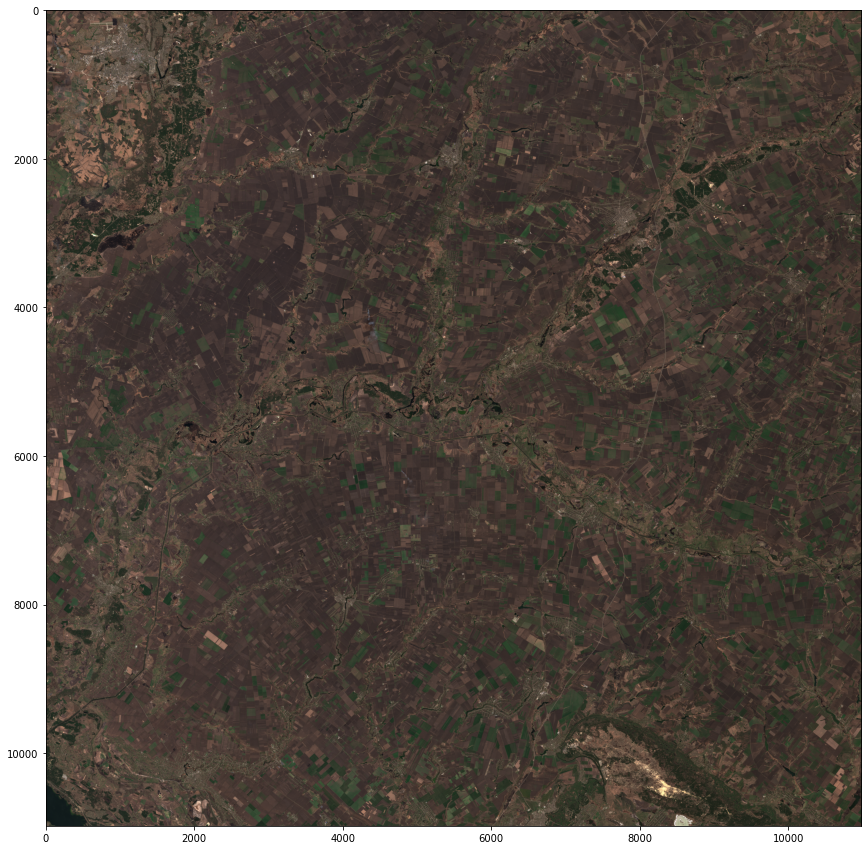

In [89]:
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

Reading train labels with GeoPandas

In [13]:
train_df = gpd.read_file("/content/drive/MyDrive/Quantum DS Test Task 4/Masks_T36UXV_20190427.shp")

ERROR:fiona._env:Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



In [11]:
train_df.head(5)

,id,Data,Code,Descriptio,Comments,Image,geometry
0,NaN,NaN,2.0,branch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,NaN,NaN,2.0,brahch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


In [17]:
train_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          0 non-null      float64 
 1   Data        0 non-null      float64 
 2   Code        340 non-null    float64 
 3   Descriptio  335 non-null    object  
 4   Comments    17 non-null     object  
 5   Image       325 non-null    object  
 6   geometry    935 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 51.3+ KB


In [13]:
train_df['Descriptio'].unique()

array(['branch of tree', 'color+ feathers', 'brahch of tree',
       'color+ feathers + branch', 'color + feathers',
       'branch + color+ feathers', 'small branch', '???', nan,
       'color+ structure', 'color (map NGO)', 'color (opodz)',
       'small tree'], dtype=object)

In [14]:
train_df[(train_df['Descriptio'] == 'color (map NGO)') | (train_df['Descriptio'] == 'color (opodz)')]

,id,Data,Code,Descriptio,Comments,Image,geometry
670,NaN,NaN,4.0,color (map NGO),NaN,T36UXV_20190427T083601,"POLYGON ((34.15309 49.62087, 34.15419 49.61951..."
687,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.35284 49.61998, 34.35357 49.62071..."
688,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.36357 49.62350, 34.36405 49.62388..."
689,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.36129 49.62502, 34.36087 49.62480..."
690,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.36497 49.62621, 34.36534 49.62612..."
691,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.37620 49.62404, 34.37672 49.62335..."
692,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.37593 49.62128, 34.37632 49.62065..."
693,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.38344 49.62222, 34.38304 49.62272..."
694,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.38729 49.62403, 34.38742 49.62423..."
695,NaN,NaN,5.0,color (opodz),opodz soil (NGO),T36UXV_20190427T083601,"POLYGON ((34.38839 49.62242, 34.38845 49.62270..."


In [15]:
train_df['Comments'].unique()

array([nan, 'It`s difficult to diagnose the type',
       'Problem with mosaic (shares)', 'M.b. problem with shares',
       'm.b. hard detection', 'opodz soil (NGO)'], dtype=object)

In [18]:
train_df['Code'].unique()

array([ 2.,  1.,  5.,  3.,  9., nan,  4.])

In [19]:
train_df['Descriptio'].unique()

array(['branch of tree', 'color+ feathers', 'brahch of tree',
       'color+ feathers + branch', 'color + feathers',
       'branch + color+ feathers', 'small branch', '???', nan,
       'color+ structure', 'color (map NGO)', 'color (opodz)',
       'small tree'], dtype=object)

Converting GeoDataframe to raster CRS & Cutting fields from Raster

In [17]:
# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = {'init' :'epsg:4326'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

/usr/local/lib/python3.9/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
train_df['id'] = range(len(train_df))

In [19]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "/content/drive/MyDrive/Quantum DS Test Task 4/output_folder"
# os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        # print('rasterio.mask')
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        # cv2.imwrite(img_path, img_image)
    except Exception as e:
        # print(str(row['id']))
        # print(e)
        failed.append(row['id'])
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 435 files


In [21]:
masked = train_df[~train_df['id'].isin(failed)]

In [24]:
failed_to_mask = train_df[train_df['id'].isin(failed)]

In [ ]:
masked = masked[masked.Code.notnull()]

<AxesSubplot:>

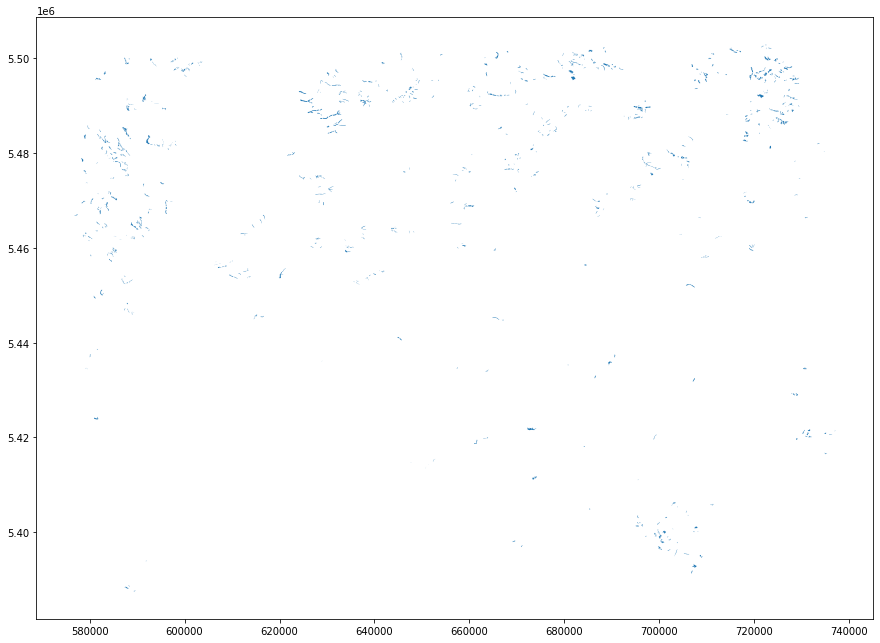

In [27]:
train_df.plot(figsize=(15,15))

<AxesSubplot:>

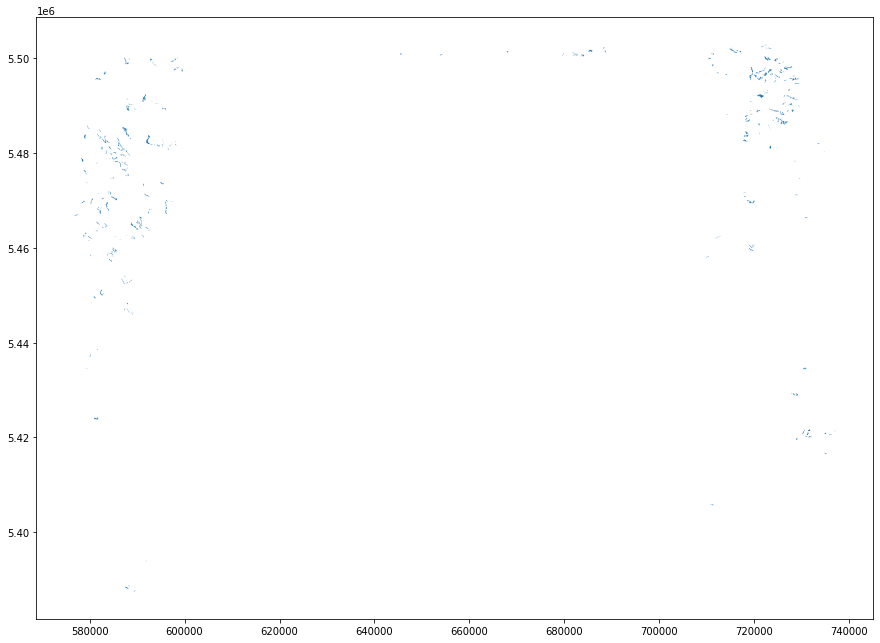

In [26]:
failed_to_mask.plot(figsize=(15,15))

<AxesSubplot:>

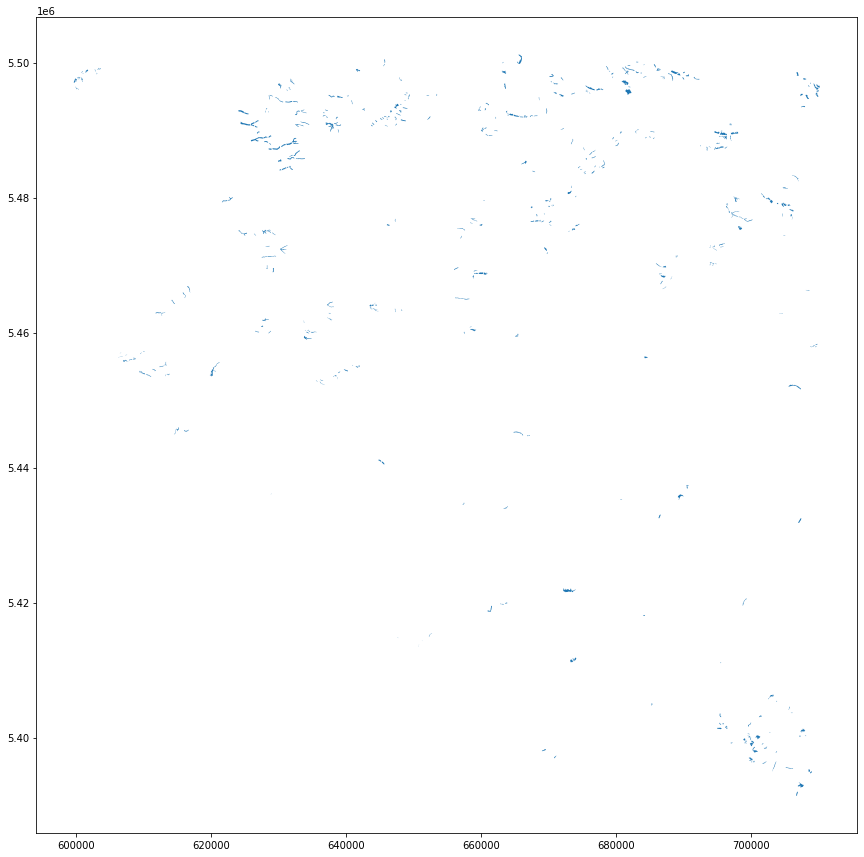

In [25]:
masked.plot(figsize=(15,15))

Checking coordinates of polygon using Polygon methods

In [30]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [689961.1517116707, 690037.4558485164, 690114.7721054466, 690121.4582230429, 690034.5817996467, 689948.2566595278, 689890.125464285, 689858.7163120923, 689886.2935119568, 689961.1517116707]),
 array('d', [5497804.66695354, 5497662.463758821, 5497572.977673752, 5497463.459960388, 5497499.930817647, 5497602.273176699, 5497714.382352993, 5497796.695564404, 5497823.999880014, 5497804.66695354]))

Preparing binary mask

In [22]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in masked.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

<ipython-input-22-32bcdff218c7>:7: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


In [ ]:
cropped_mask_path = '/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_mask'

In [ ]:
import image_slicer

In [ ]:
image_slicer.slice('/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_mask/mask.jp2', 4096)

In [ ]:
image_slicer.slice('/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_raster/raster.jp2', 4096)

In [ ]:
file_dir = '/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_raster'
file_names = os.listdir(file_dir)
file_names = file_names[1:]
len(file_names)

4096

In [ ]:
def find_masked(file_names, file_dir):
  li = []
  for file_name in file_names:
    # print(file_name)
    img_array = cv2.imread(file_dir+'/'+file_name)
    next = False
    for dim1 in img_array:
      for dim2 in dim1:
        if np.any(dim2>10):
          li.append(file_name)
          next = True
          break
      if next:
        next = False
        break
  return li

In [ ]:
li = find_masked(file_names, file_dir)

In [ ]:
li_df = pd.DataFrame({'masked':li})

In [ ]:
li_df.to_csv('/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_mask/files_that_have_erosion')

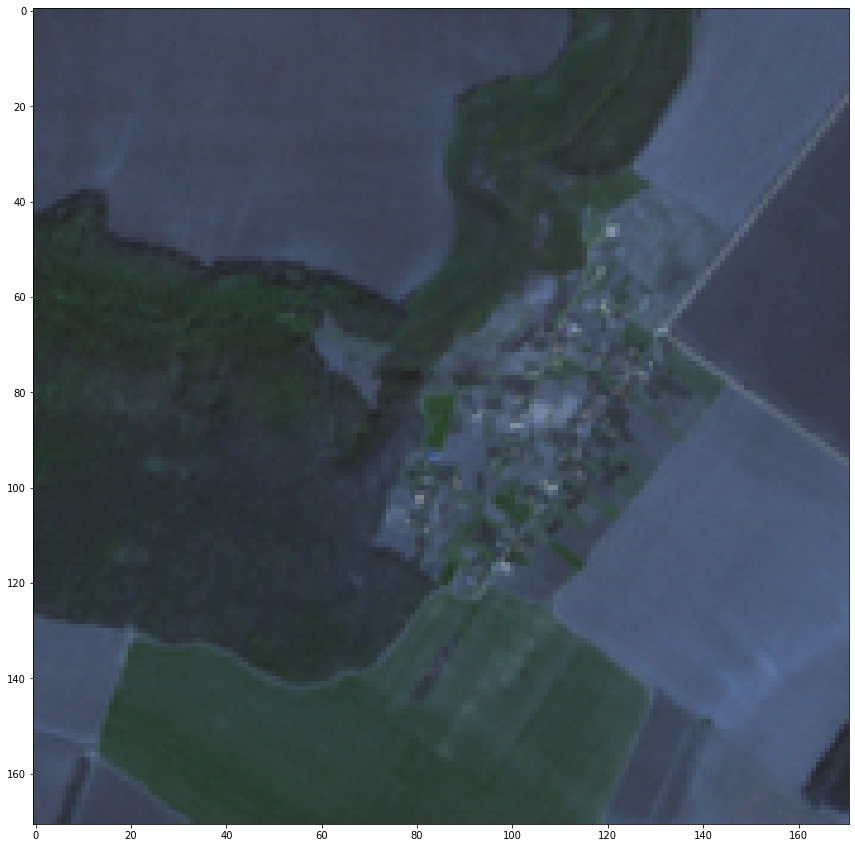

In [33]:
img_array = cv2.imread('/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_raster/raster_01_01.png')
plt.figure(figsize=(15,15))
plt.imshow(img_array)

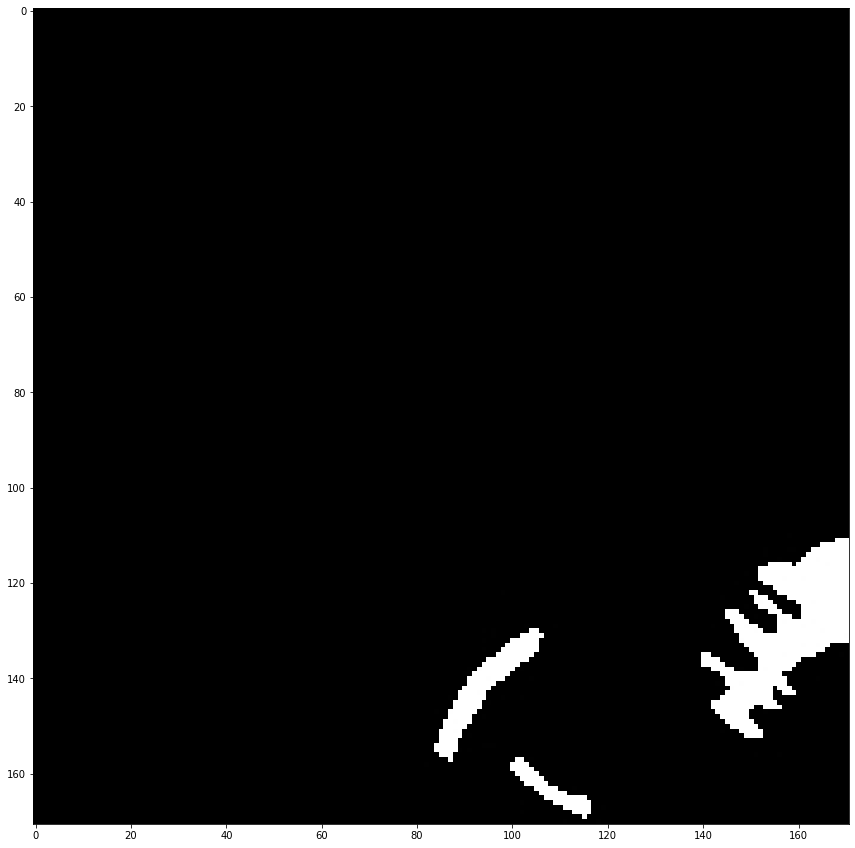

In [35]:
img_array = cv2.imread('/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_mask/mask_01_01.png')
plt.figure(figsize=(15,15))
plt.imshow(img_array)

Saving binary mask

In [ ]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("/content/drive/MyDrive/Quantum DS Test Task 4/cropped_data/cropped_mask/mask.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask, 1)

In [101]:
# img_array = cv2.imread(raster_img)

In [7]:
img_array2 = raster_img

In [8]:
img_array2.shape

(10980, 10980, 3)

In [23]:
masked0 = cv2.bitwise_and(img_array2, img_array2, mask= mask)

In [24]:
masked = cv2.bitwise_xor(img_array2, masked0)

In [25]:
hsv=cv2.cvtColor(masked,cv2.COLOR_BGR2HSV)

In [26]:
lo=np.array([0,0,0])
hi=np.array([0,0,0])

In [27]:
mask=cv2.inRange(hsv,lo,hi)

In [28]:
img_array2[mask>0]=(0,0,255)

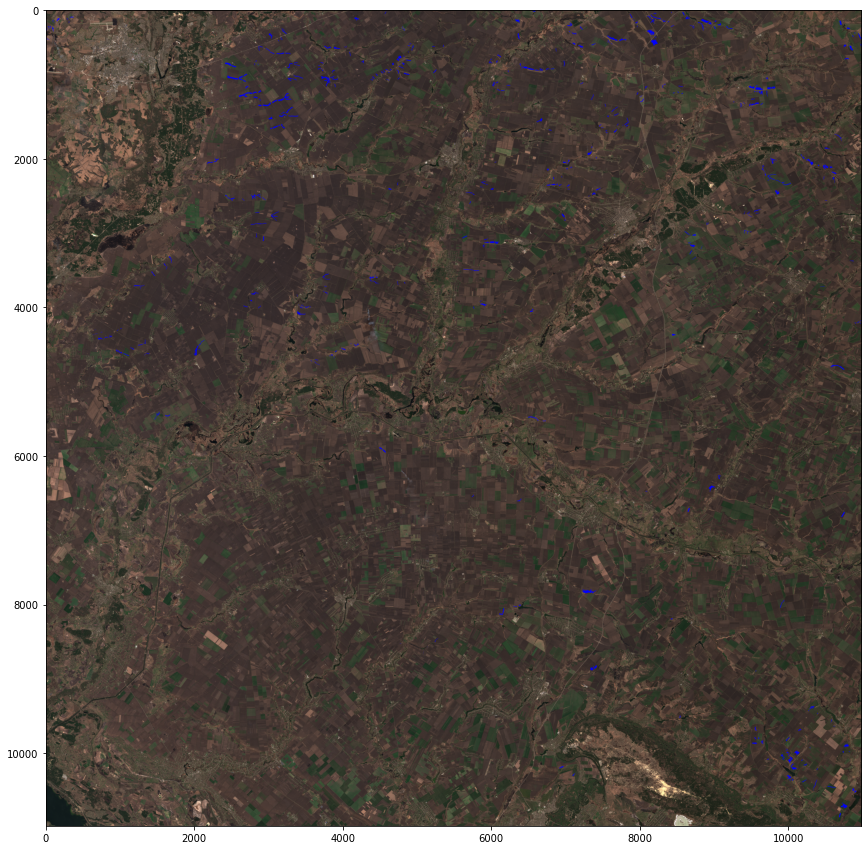

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(img_array2)